In [1]:
import numpy as np

In [26]:
x = np.load('configf_1200_big_15rots_REG_alms/trajectory_alms.npz')
x['phase_bg']

array([[[-6.51431179e+00-3.99571848e+00j,
          1.70748539e+01-1.78567004e+00j,
         -5.50183201e+00-1.80031943e+00j],
        [-4.02191430e-01+2.23628268e-01j,
         -1.61437348e-01+1.22536002e-02j,
         -5.38184464e-01-2.63227940e-01j],
        [ 1.08832514e+00+2.91882098e-01j,
         -2.28259489e-01+1.83121309e-01j,
         -4.86338466e-01-1.16372275e+00j],
        ...,
        [ 2.17541587e-02+8.38214755e-02j,
         -6.85570598e-01-1.16080254e-01j,
         -4.00376886e-01-1.80315033e-01j],
        [ 1.37587667e-01+1.22494392e-01j,
         -2.52548829e-02-6.82467341e-01j,
          1.80269778e-02+4.82225537e-01j],
        [ 2.76080459e-01-2.77533293e-01j,
         -6.92295611e-01+2.59277970e-01j,
         -4.35286373e-01+7.19271824e-02j]],

       [[ 3.89424515e+00-2.60289335e+00j,
         -7.63031816e+00-3.39389157e+00j,
          4.70641994e+00+4.68216991e+00j],
        [-1.71413571e-02+7.41377950e-01j,
         -1.20063496e+00-5.11148214e-01j,
          8.

/tmp/ipykernel_138561/3609178267.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  k: v.astype(np.float64)
/home/tim/anaconda3/envs/deepsphere_env/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tim/anaconda3/envs/deepsphere_env/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


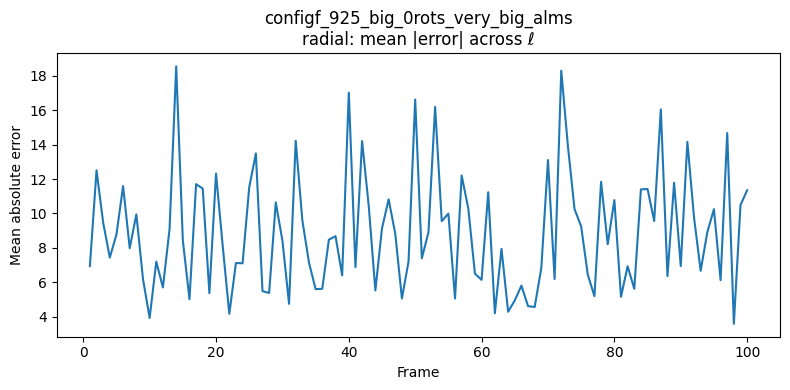

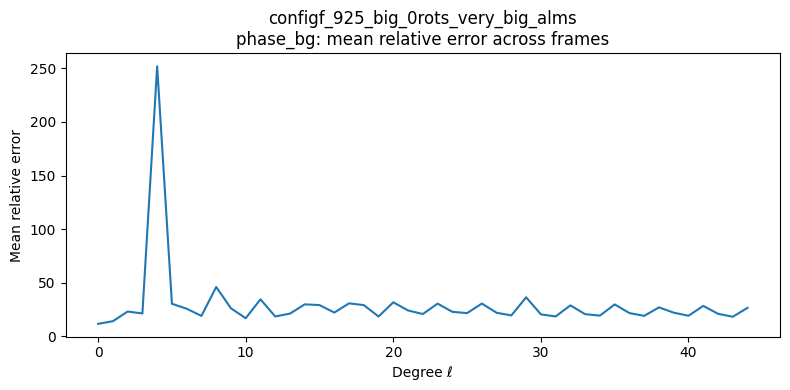

In [14]:
"""
Compute per-frame SH-coefficient errors (absolute + relative) for every
prediction model vs its ground-truth latent space.

Directory layout (new):
.
├── configf_925_big_0rots_very_big_alms/         <-- prediction folders (root_pred)
│   └── trajectory_alms.npz
├── configf_925_big_15rots_REG_alms/
│   └── trajectory_alms.npz
└── ..                                           <-- one level up (root_truth)
    ├── configf_925/
    │   ├── outer_sh_radial_latent.npy
    │   └── ...
    └── configf_1200/
        └── ...
"""

from __future__ import annotations
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt


# --------------------------- configuration ----------------------------------
LMAX = dict(radial=14, phase_fg=22, phase_bg=44)      # ℓ-max per data-key
EPS  = 1e-12                                          # avoid 0-division
# ----------------------------------------------------------------------------


def l_map(lmax: int) -> np.ndarray:
    """ℓ index for each Alm coefficient (healpy: m fastest)."""
    return hp.Alm.getlm(lmax)[0]


def discover_prediction_folders(root_pred: Path) -> dict[Path, str]:
    """Find subdirs with `trajectory_alms.npz`; map → cfg_id string."""
    folders = {}
    for npz in root_pred.rglob("trajectory_alms.npz"):
        m = re.search(r"configf_(\d+)", str(npz.parent))
        if m:
            folders[npz.parent] = m.group(1)
    return folders


def load_predictions(pred_dir: Path) -> dict[str, np.ndarray]:
    return {
        k: v.astype(np.float64)
        for k, v in np.load(pred_dir / "trajectory_alms.npz").items()
    }


def load_ground_truth(root_truth: Path, cfg_id: str) -> dict[str, np.ndarray]:
    gt_dir = root_truth / f"configf_{cfg_id}"
    return {
        "radial":   np.load(gt_dir / "outer_sh_radial_latent.npy"),
        "phase_fg": np.load(gt_dir / "outer_sh_phase_latent_fg_lmax22.npy"),
        "phase_bg": np.load(gt_dir / "outer_sh_phase_latent_bg_lmax44.npy"),
    }


def flatten_channels(arr: np.ndarray) -> np.ndarray:
    return arr.reshape(arr.shape[0], -1) if arr.ndim == 3 else arr


def repeat_l_for_channels(l_base: np.ndarray, arr: np.ndarray) -> np.ndarray:
    reps = arr.shape[1] // l_base.size
    return np.tile(l_base, reps)


def compute_stats_for_pair(pred_dir: Path,
                           cfg_id: str,
                           root_truth: Path) -> pd.DataFrame:
    pred   = load_predictions(pred_dir)
    truth  = load_ground_truth(root_truth, cfg_id)

    rows = []
    for key, p in pred.items():
        t = truth[key][1:101]                  # truth frames 1–100
        p = flatten_channels(p)
        t = flatten_channels(t)

        l_base = l_map(LMAX[key])
        l_full = repeat_l_for_channels(l_base, p)

        for frame in range(100):
            diff = np.abs(p[frame] - t[frame])
            rel  = diff / (np.abs(t[frame]) + EPS)

            for L in np.unique(l_full):
                mask = l_full == L
                rows.append(
                    {
                        "model":        pred_dir.name,
                        "field":        key,
                        "frame":        frame + 1,
                        "degree":       int(L),
                        "mean_abs_err": diff[mask].mean(),
                        "sd_abs_err":   diff[mask].std(ddof=1),
                        "mean_rel_err": rel[mask].mean(),
                    }
                )
    return pd.DataFrame(rows)


def build_dataframe(root_pred: str | os.PathLike = ".",
                    root_truth: str | os.PathLike = "../") -> pd.DataFrame:
    """Assemble stats for all prediction folders under `root_pred`
       versus ground truth under `root_truth`."""
    root_pred   = Path(root_pred).resolve()
    root_truth  = Path(root_truth).resolve()

    dfs = [
        compute_stats_for_pair(pred_dir, cfg_id, root_truth)
        for pred_dir, cfg_id in discover_prediction_folders(root_pred).items()
    ]
    return (
        pd.concat(dfs, ignore_index=True)
          .sort_values(["model", "field", "degree", "frame"])
    )


# ----------------------------- plotting helpers -----------------------------
def plot_mean_abs_vs_frame(df: pd.DataFrame, model: str, field: str):
    sub = (df.query("model == @model and field == @field")
             .groupby("frame")["mean_abs_err"].mean())
    plt.figure(figsize=(8, 4))
    plt.plot(sub.index, sub.values)
    plt.title(f"{model}\n{field}: mean |error| across ℓ")
    plt.xlabel("Frame"); plt.ylabel("Mean absolute error"); plt.tight_layout()
    plt.show()


def plot_mean_rel_vs_degree(df: pd.DataFrame, model: str, field: str):
    sub = (df.query("model == @model and field == @field")
             .groupby("degree")["mean_rel_err"].mean())
    plt.figure(figsize=(8, 4))
    plt.plot(sub.index, sub.values)
    plt.title(f"{model}\n{field}: mean relative error across frames")
    plt.xlabel("Degree ℓ"); plt.ylabel("Mean relative error"); plt.tight_layout()
    plt.show()


# --------------------------------------------------------------------------- #
# Example CLI usage
# --------------------------------------------------------------------------- #
if __name__ == "__main__":
    df = build_dataframe(root_pred=".", root_truth="../")
    df.to_csv("sh_error_stats.csv", index=False)

    plot_mean_abs_vs_frame(df,
                           model="configf_925_big_0rots_very_big_alms",
                           field="radial")
    plot_mean_rel_vs_degree(df,
                            model="configf_925_big_0rots_very_big_alms",
                            field="phase_bg")


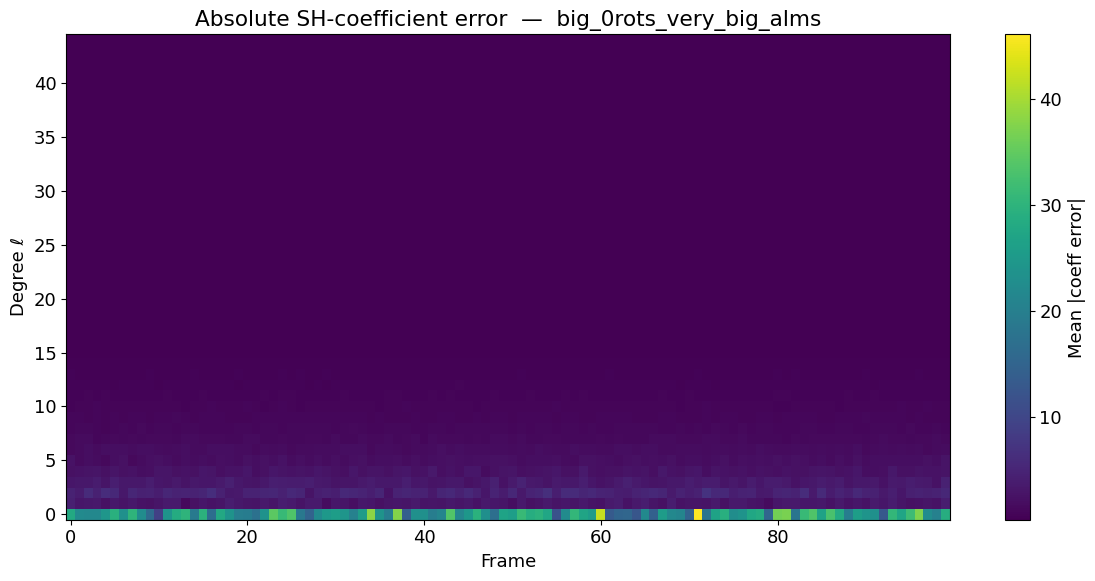

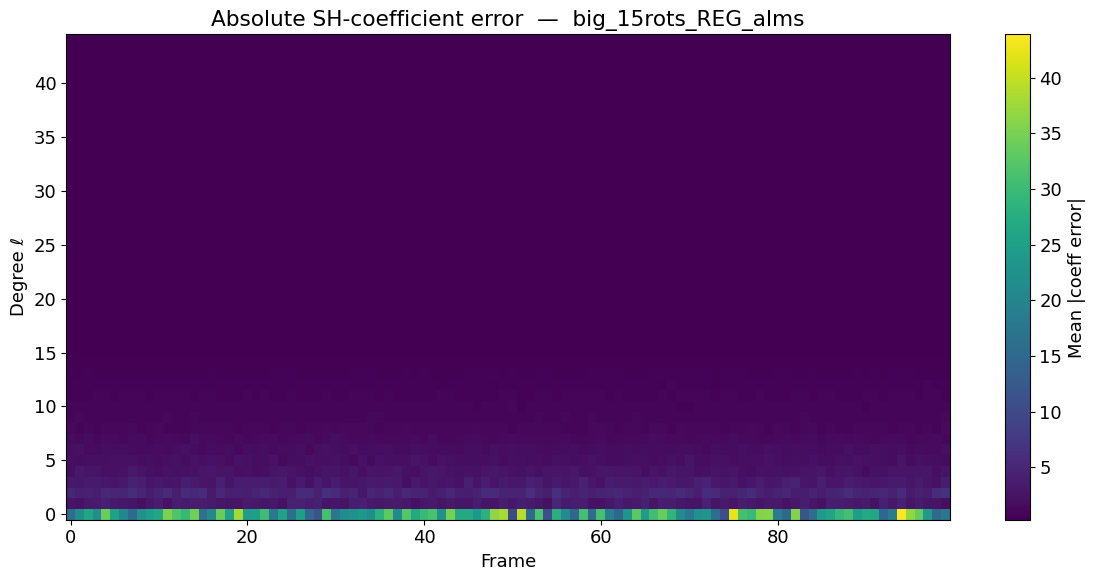

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ------------------------------------------------------------------
# 1)  Load the per-frame, per-degree statistics table
# ------------------------------------------------------------------
# If you kept the in-memory DataFrame:
#     df = your_dataframe_variable
# …or if you saved it (pickle / CSV), read it back:
df = pd.read_csv("sh_error_stats.csv")          # or pd.read_csv(...)

# ------------------------------------------------------------------
# 2)  Collapse “configf_<id>_...” → model flavour
# ------------------------------------------------------------------
df["model_type"] = df["model"].str.replace(r"^configf_\d+_", "",
                                           regex=True)

# ------------------------------------------------------------------
# 3)  Average |error| across ALL folders that share the same flavour
# ------------------------------------------------------------------
agg = (df.groupby(["model_type", "frame", "degree"],
                  as_index=False)["mean_abs_err"]
         .mean())

# ------------------------------------------------------------------
# 4)  Build and plot one heat-map per model flavour
# ------------------------------------------------------------------
for model in agg["model_type"].unique():
    sub = agg[agg["model_type"] == model]

    # Pivot to 2-D array: rows = ℓ, cols = frame
    heat = (sub.pivot(index="degree",
                      columns="frame",
                      values="mean_abs_err")
               # ensure full rectangular grid  ℓ = 0…44, frame = 1…100
               .reindex(index=np.arange(0, 45),
                        columns=np.arange(1, 101)))

    plt.figure(figsize=(12, 6))
    im = plt.imshow(heat, aspect="auto",
                    origin="lower", interpolation="nearest")
    plt.colorbar(im, label="Mean |coeff error|")
    plt.title(f"Absolute SH-coefficient error  —  {model}")
    plt.xlabel("Frame")
    plt.ylabel("Degree ℓ")
    plt.tight_layout()
    plt.show()


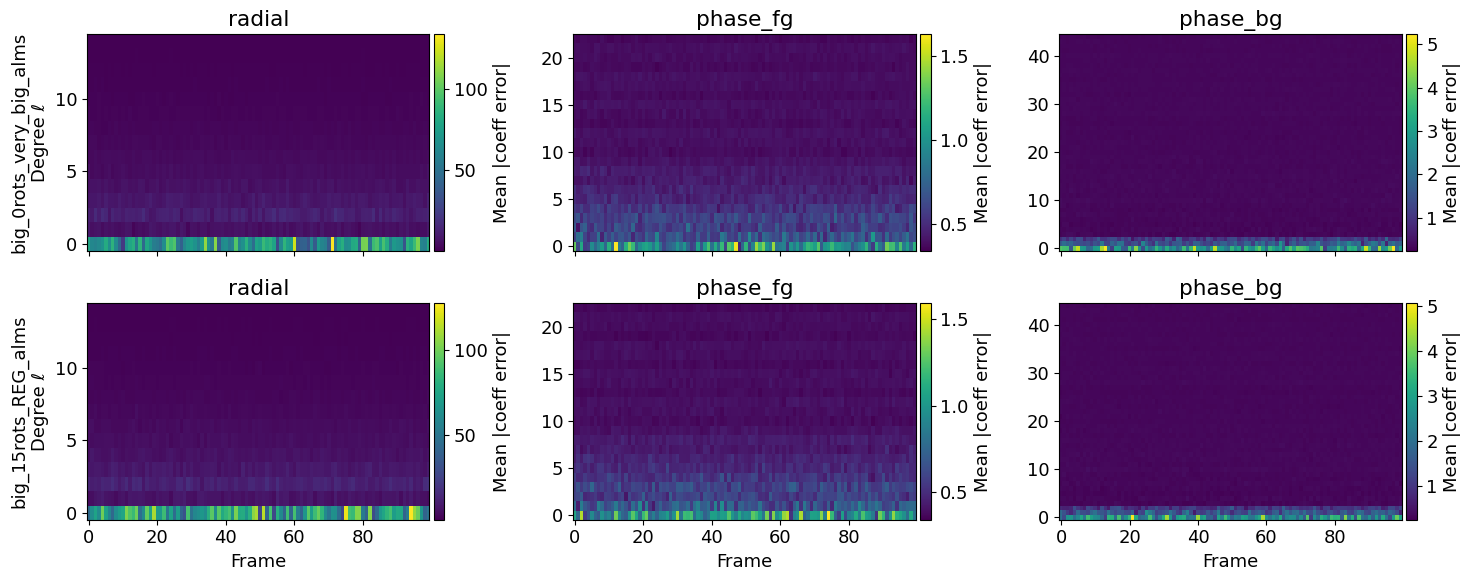

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ─────────────────────────────────────────────────────────────
# 1)  Load the per-frame, per-degree statistics table
# ─────────────────────────────────────────────────────────────
df = pd.read_csv("sh_error_stats.csv")          # or .read_pickle(...)

# ─────────────────────────────────────────────────────────────
# 2)  Derive a clean model label: strip the numeric prefix
# ─────────────────────────────────────────────────────────────
df["model_type"] = df["model"].str.replace(r"^configf_\d+_", "",
                                           regex=True)

# ─────────────────────────────────────────────────────────────
# 3)  Field-specific ℓ-max (so the colourbars sit right)
# ─────────────────────────────────────────────────────────────
LMAX = {"radial": 14, "phase_fg": 22, "phase_bg": 44}

# average across folders that share the same model flavour
agg = (df.groupby(["model_type", "field", "frame", "degree"],
                  as_index=False)["mean_abs_err"]
         .mean())

models = sorted(agg["model_type"].unique())
fields = ["radial", "phase_fg", "phase_bg"]

fig, axes = plt.subplots(len(models), len(fields),
                         figsize=(len(fields)*5, len(models)*3),
                         sharex=True, sharey=False)

for r, model in enumerate(models):
    for c, field in enumerate(fields):
        ax = axes[r, c] if len(models) > 1 else axes[c]

        sub = agg.query("model_type == @model and field == @field")

        heat = (sub.pivot(index="degree", columns="frame", values="mean_abs_err")
                   .reindex(index=np.arange(0, LMAX[field]+1),
                            columns=np.arange(1, 101)))

        im = ax.imshow(heat, aspect="auto", origin="lower",
                       interpolation="nearest")
        if c == 0:
            ax.set_ylabel(f"{model}\nDegree ℓ")
        if r == len(models)-1:
            ax.set_xlabel("Frame")
        ax.set_title(field)

        # one colourbar per subplot (comment out for a single global bar)
        cbar = plt.colorbar(im, ax=ax, pad=0.01)
        cbar.set_label("Mean |coeff error|")

plt.tight_layout()
plt.show()


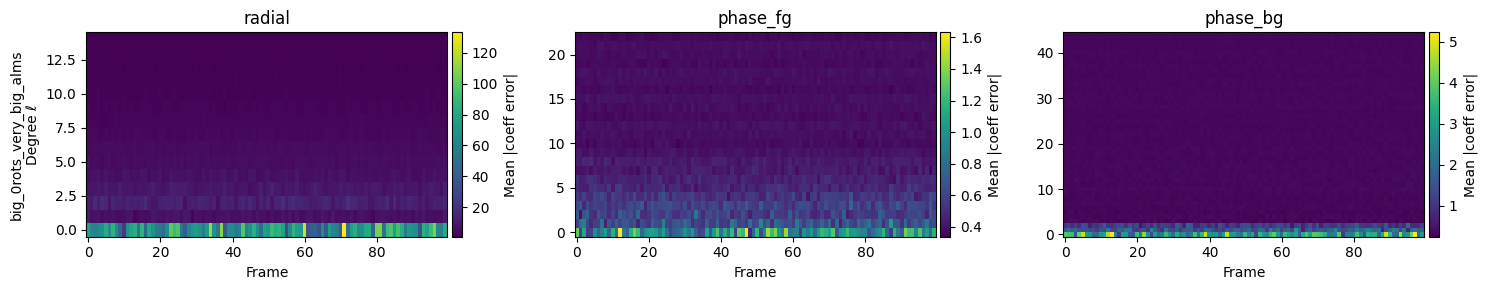

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ─────────────────────────────────────────────────────────────
# 1)  Load the per-frame, per-degree statistics table
# ─────────────────────────────────────────────────────────────
df = pd.read_csv("sh_error_stats.csv")          # or .read_pickle(...)

# ─────────────────────────────────────────────────────────────
# 2)  Derive a clean model label: strip the numeric prefix
# ─────────────────────────────────────────────────────────────
df["model_type"] = df["model"].str.replace(r"^configf_\d+_", "",
                                           regex=True)

# ─────────────────────────────────────────────────────────────
# 3)  Field-specific ℓ-max (so the colourbars sit right)
# ─────────────────────────────────────────────────────────────
LMAX = {"radial": 14, "phase_fg": 22, "phase_bg": 44}

# average across folders that share the same model flavour
agg = (df.groupby(["model_type", "field", "frame", "degree"],
                  as_index=False)["mean_abs_err"]
         .mean())

#models = sorted(agg["model_type"].unique())
models = ['big_0rots_very_big_alms']
fields = ["radial", "phase_fg", "phase_bg"]

fig, axes = plt.subplots(len(models), len(fields),
                         figsize=(len(fields)*5, len(models)*3),
                         sharex=True, sharey=False)

for r, model in enumerate(models):
    for c, field in enumerate(fields):
        ax = axes[r, c] if len(models) > 1 else axes[c]

        sub = agg.query("model_type == @model and field == @field")

        heat = (sub.pivot(index="degree", columns="frame", values="mean_abs_err")
                   .reindex(index=np.arange(0, LMAX[field]+1),
                            columns=np.arange(1, 101)))

        im = ax.imshow(heat, aspect="auto", origin="lower",
                       interpolation="nearest")
        if c == 0:
            ax.set_ylabel(f"{model}\nDegree ℓ")
        if r == len(models)-1:
            ax.set_xlabel("Frame")
        ax.set_title(field)

        # one colourbar per subplot (comment out for a single global bar)
        cbar = plt.colorbar(im, ax=ax, pad=0.01)
        cbar.set_label("Mean |coeff error|")

plt.tight_layout()
plt.show()


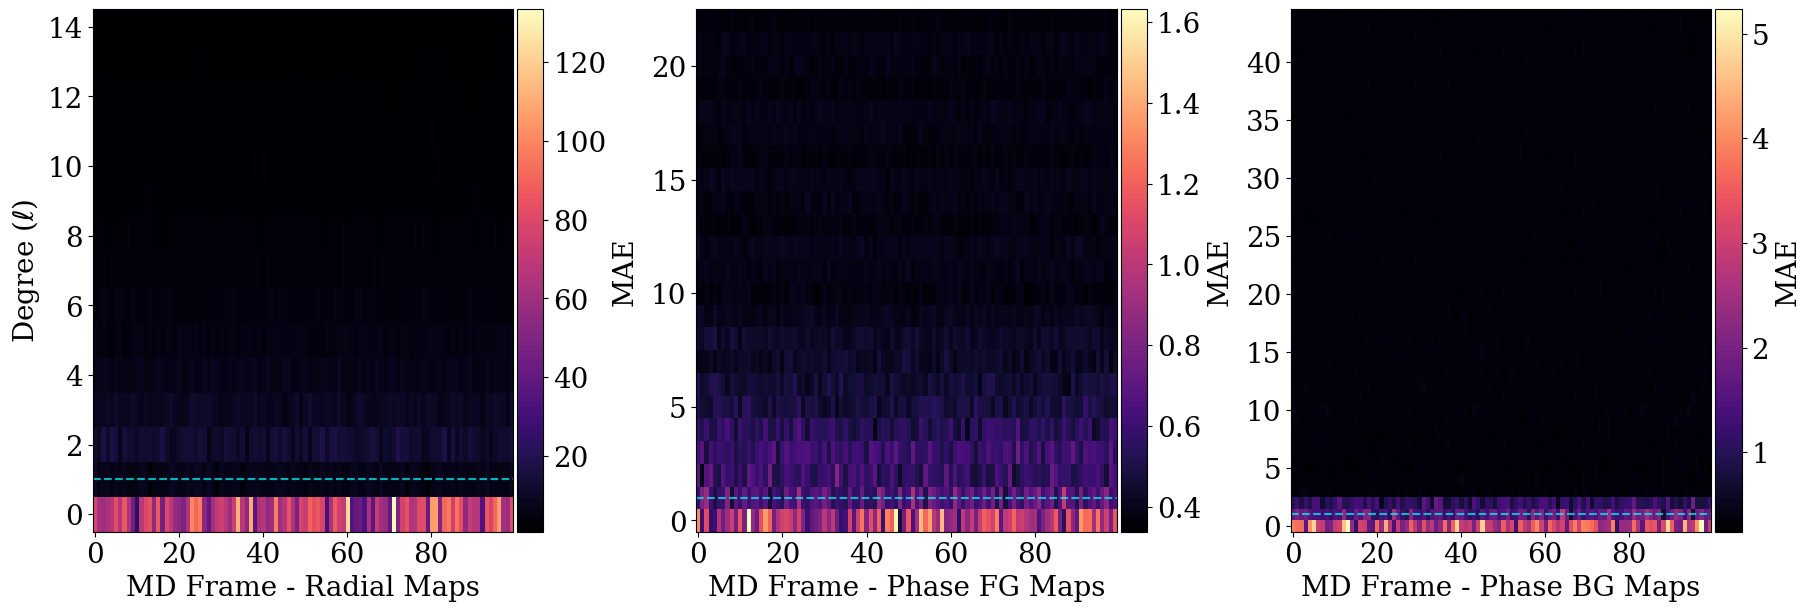

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# --- Matplotlib Font Setup ---
# Set general font family for publication quality
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "font.size": 12 # Base font size
})

# Define font sizes for better readability
LABEL_FONTSIZE = 20
TICK_FONTSIZE = 20
CBAR_LABEL_FONTSIZE = 20

# --- Custom X-axis Label Dictionary ---
# You can define your desired x-axis labels here for each field.
x_axis_label_names = {
    "radial": "MD Frame - Radial Maps",
    "phase_fg": "MD Frame - Phase FG Maps",
    "phase_bg": "MD Frame - Phase BG Maps",
}
# ------------------------------------

# ─────────────────────────────────────────────────────────────
# 1)  Load the per-frame, per-degree statistics table
# ─────────────────────────────────────────────────────────────
df = pd.read_csv("sh_error_stats.csv")  # or .read_pickle(...)

# ─────────────────────────────────────────────────────────────
# 2)  Derive a clean model label: strip the numeric prefix
# ─────────────────────────────────────────────────────────────
df["model_type"] = df["model"].str.replace(r"^configf_\d+_", "",
                                          regex=True)

# ─────────────────────────────────────────────────────────────
# 3)  Field-specific ℓ-max (so the colourbars sit right)
# ─────────────────────────────────────────────────────────────
LMAX = {"radial": 14, "phase_fg": 22, "phase_bg": 44}

# Average across folders that share the same model flavour
agg = (df.groupby(["model_type", "field", "frame", "degree"],
                  as_index=False)["mean_abs_err"]
           .mean())

models = ['big_0rots_very_big_alms'] # Keeping this as per your request
fields = ["radial", "phase_fg", "phase_bg"]

# --- Plotting Setup ---
fig, axes = plt.subplots(len(models), len(fields),
                         figsize=(len(fields)*6, len(models)*6), # Adjusted figsize for larger fonts
                         sharex=True, sharey=False,
                         constrained_layout=True)

# Handle the case where there's only one row (i.e., len(models) == 1)
# In this case, axes will be a 1D array, not 2D.
if len(models) == 1:
    axes = np.array([axes]) # Make it 2D for consistent indexing


# Loop through models (rows) and fields (columns)
for r, model in enumerate(models):
    for c, field in enumerate(fields):
        ax = axes[r, c]

        sub = agg.query("model_type == @model and field == @field")

        heat = (sub.pivot(index="degree", columns="frame", values="mean_abs_err")
                   .reindex(index=np.arange(0, LMAX[field]+1),
                            columns=np.arange(1, 101)))

        # Plot the heatmap
        im = ax.imshow(heat, aspect="auto", origin="lower",
                        interpolation="nearest", cmap="magma")

        # --- Customize Labels and Ticks ---
        # Set Y-axis label: "Degree ell" only, no model title
        if c == 0: # Only for the first column
            ax.set_ylabel(r"Degree ($\ell$)", fontsize=LABEL_FONTSIZE)
        
        # Set X-axis label using the custom dictionary
        if r == len(models) - 1: # Only for the last row
            ax.set_xlabel(x_axis_label_names.get(field, f"Frame ({field})"), fontsize=LABEL_FONTSIZE)

        # Set tick parameters
        ax.tick_params(axis='x', labelsize=TICK_FONTSIZE)
        ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)

        # Add horizontal line at ell=1 for reference
        ax.axhline(1, color='cyan', ls='--', lw=1.5, alpha=0.7)

        # Add colorbar for each subplot
        cbar = plt.colorbar(im, ax=ax, pad=0.01)
        cbar.set_label("MAE", fontsize=CBAR_LABEL_FONTSIZE) # Renamed colorbar label
        cbar.ax.tick_params(labelsize=TICK_FONTSIZE) # Adjust colorbar tick font size

# No overall title as requested
plt.savefig('interpolation_frame_mae.png', dpi=300)
plt.show()

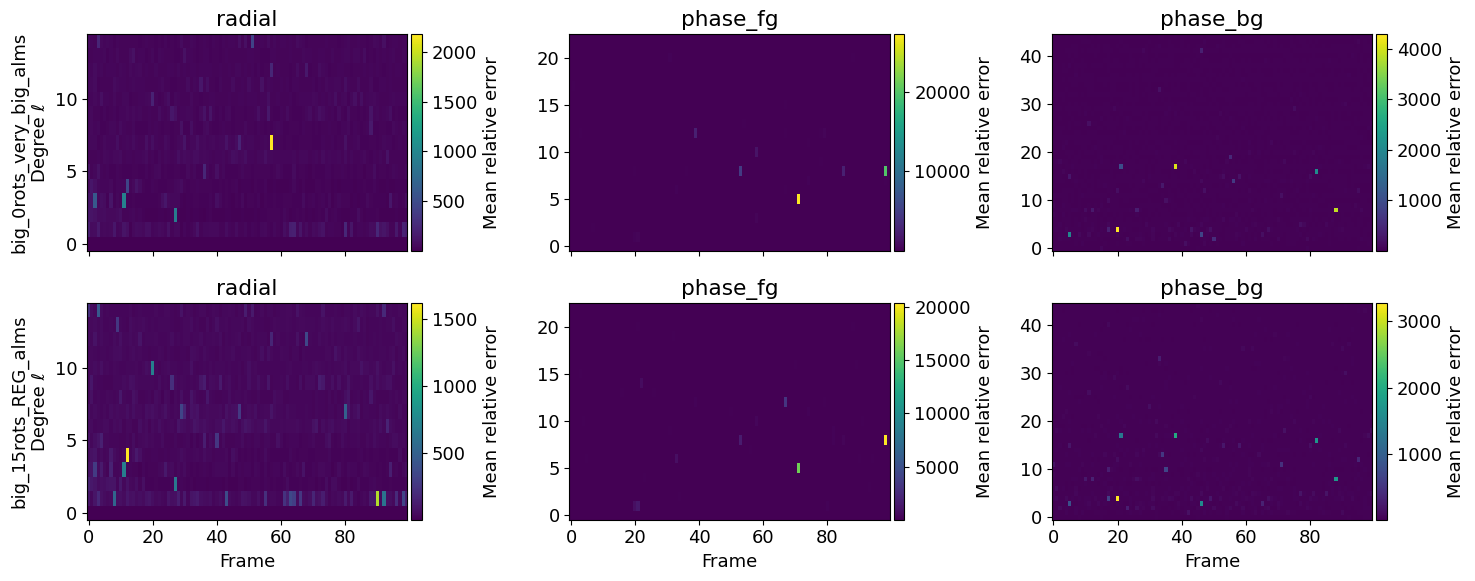

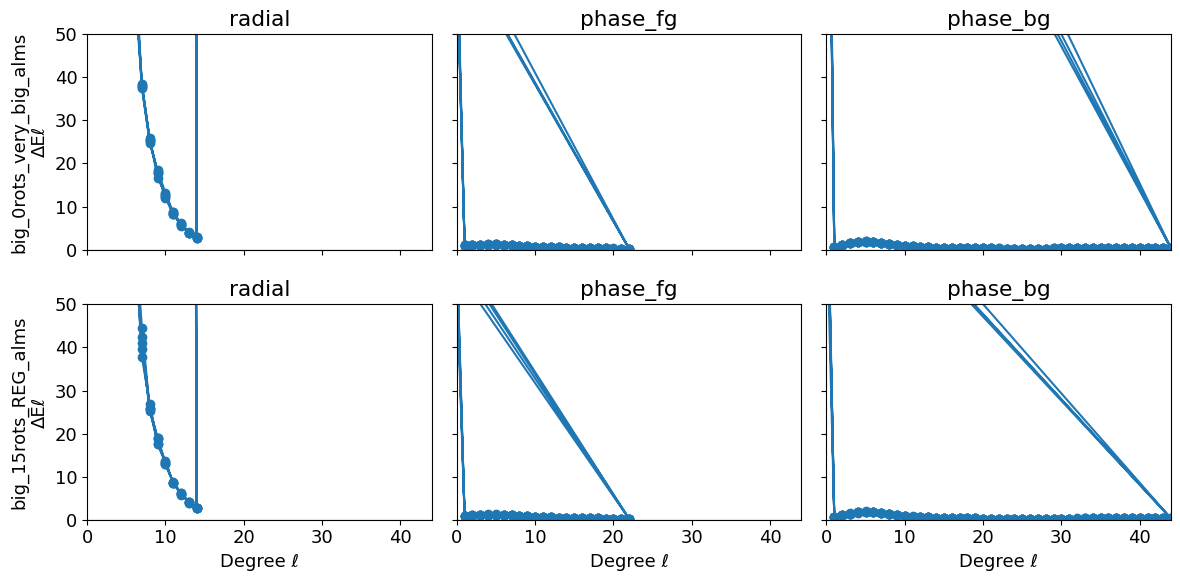

In [40]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, healpy as hp, re, os
from pathlib import Path

# ───────────────── user paths ──────────────────────────────
ERR_TABLE   = "sh_error_stats.csv"           # already generated
ROOT_PRED   = "."                            # prediction folders
ROOT_TRUTH  = "../"                          # configf_<id> truth folders
LMAX        = {"radial": 14, "phase_fg": 22, "phase_bg": 44}

# ───────────────── 1) 2×3 relative-error heat-maps ─────────
df = pd.read_csv(ERR_TABLE)
df["model_type"] = df["model"].str.replace(r"^configf_\d+_", "", regex=True)

rel = (df.groupby(["model_type", "field", "frame", "degree"], as_index=False)
         ["mean_rel_err"].mean())

models = sorted(rel.model_type.unique())
fields = ["radial", "phase_fg", "phase_bg"]

fig, axes = plt.subplots(len(models), len(fields),
                         figsize=(len(fields)*5, len(models)*3),
                         sharex=True, sharey=False)

for r, mdl in enumerate(models):
    for c, fld in enumerate(fields):
        ax = axes[r, c] if len(models) > 1 else axes[c]
        sub = rel.query("model_type == @mdl and field == @fld")
        heat = (sub.pivot(index="degree", columns="frame", values="mean_rel_err")
                  .reindex(index=np.arange(0, LMAX[fld]+1),
                           columns=np.arange(1, 101)))
        im = ax.imshow(heat, aspect="auto", origin="lower", interpolation="nearest")
        if c == 0: ax.set_ylabel(f"{mdl}\nDegree ℓ")
        if r == len(models)-1: ax.set_xlabel("Frame")
        ax.set_title(fld)
        plt.colorbar(im, ax=ax, pad=0.01).set_label("Mean relative error")
plt.tight_layout()
plt.show()

# ───────────────── 2) power-spectrum residual  ─────────────
def alm_degree_map(lmax):
    l_idx, _ = hp.Alm.getlm(lmax)
    return l_idx

def collect_energy_per_degree():
    """Return DataFrame: (model_type, field, degree) → mean Eℓ over frames+folders."""
    rows = []
    pred_dirs = [p for p in Path(ROOT_PRED).glob("configf_*_alms") if p.is_dir()]
    for pred_dir in pred_dirs:
        cfg_id = re.search(r"configf_(\d+)", pred_dir.name).group(1)
        model_type = re.sub(r"^configf_\d+_", "", pred_dir.name)
        truth_dir = Path(ROOT_TRUTH) / f"configf_{cfg_id}"

        # load trajectories
        traj = np.load(pred_dir / "trajectory_alms.npz")
        truth_rad = np.load(truth_dir / "outer_sh_radial_latent.npy")      # (101,120,1)
        truth_fg  = np.load(truth_dir / "outer_sh_phase_latent_fg_lmax22.npy")
        truth_bg  = np.load(truth_dir / "outer_sh_phase_latent_bg_lmax44.npy")

        for field, pred_arr, true_arr in [
            ("radial",   traj["radial"],   truth_rad[...,0]),              # drop chan
            ("phase_fg", traj["phase_fg"], truth_fg),
            ("phase_bg", traj["phase_bg"], truth_bg),
        ]:
            # reshape to (frames, coeffs, chan)
            if pred_arr.ndim == 2: pred_arr = pred_arr[..., None]
            if true_arr.ndim == 2: true_arr = true_arr[..., None]

            # align frames 0..99 with truth 1..100
            true_arr = true_arr[1:101]

            lmax = LMAX[field]
            l_idx = alm_degree_map(lmax)           # (coeff,)
            for ℓ in range(lmax+1):
                mask = l_idx == ℓ
                # sum over m and channel, average over frames
                E_pred = np.abs(pred_arr[:, mask, :])**2
                E_true = np.abs(true_arr[:, mask, :])**2
                dE = E_pred.mean() - E_true.mean()
                rows.append({"model_type": model_type,
                             "field": field, "degree": ℓ, "dE": float(dE)})
    return pd.DataFrame(rows)

spec = collect_energy_per_degree()

# line plot per (model, field)
fig, axes = plt.subplots(len(models), len(fields),
                         figsize=(len(fields)*4, len(models)*3),
                         sharex=True, sharey=True)
for r, mdl in enumerate(models):
    for c, fld in enumerate(fields):
        ax = axes[r, c] if len(models) > 1 else axes[c]
        sub = spec.query("model_type == @mdl and field == @fld")
        ax.axhline(0, color="k", lw=0.8)
        ax.plot(sub.degree, sub.dE, marker='o')
        if r == len(models)-1: ax.set_xlabel("Degree ℓ")
        if c == 0: ax.set_ylabel(f"{mdl}\nΔEℓ")
        ax.set_title(fld); ax.set_xlim(0, LMAX[fld]); ax.set_ylim(0,50)
plt.tight_layout()
plt.show()


Generating Plot 1: Relative Error Heatmaps for model 'big_0rots_very_big_alms'...
Model types found in 'sh_error_stats.csv': ['big_0rots_very_big_alms' 'big_15rots_REG_alms']
Number of rows in 'rel' DataFrame after filtering for 'big_0rots_very_big_alms': 8300


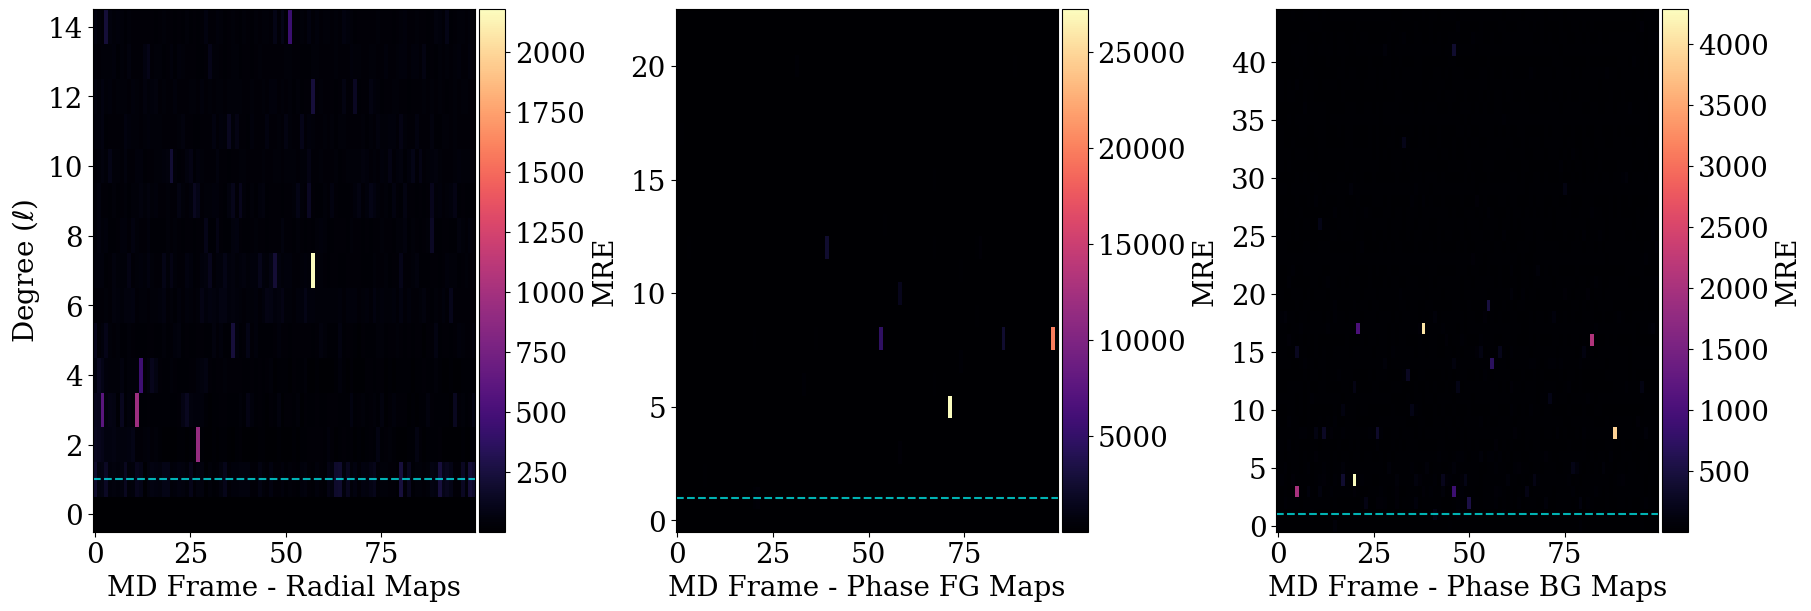


Finished Plot 1.
Generating Plot 2: Power Spectrum Residuals for model 'big_0rots_very_big_alms'...
Number of rows in 'spec' DataFrame after collection: 415


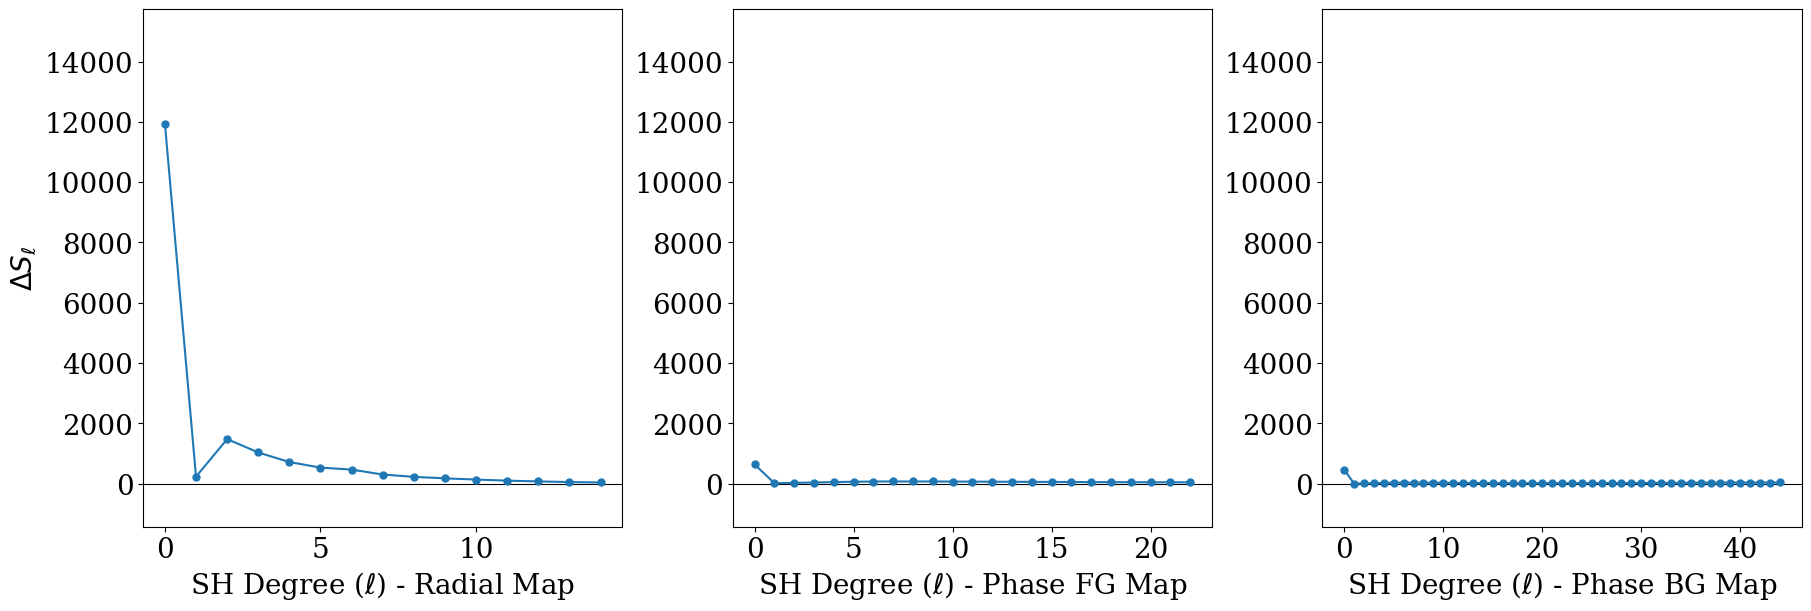


Finished Plot 2.


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, healpy as hp, re, os
from pathlib import Path

# --- User Paths and General Constants ---
ERR_TABLE   = "sh_error_stats.csv"         # Error statistics table
ROOT_PRED   = "."                          # Prediction folders
ROOT_TRUTH  = "../"                        # Truth folders
LMAX        = {"radial": 14, "phase_fg": 22, "phase_bg": 44} # Field-specific LMAX
fields      = ["radial", "phase_fg", "phase_bg"] # Fields to plot

# >>> IMPORTANT: This target model name must match exactly what's in your CSV after processing! <<<
target_model = 'big_0rots_very_big_alms'

# --- Matplotlib Font & Label Customization ---
plt.rcParams.update({
    "text.usetex": False, # Ensure LaTeX is disabled for general plotting
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "font.size": 12 # Base font size
})

# Define font sizes as per your request
LABEL_FONTSIZE = 20
TICK_FONTSIZE = 20
CBAR_LABEL_FONTSIZE = 20

# Custom X-axis label dictionary for Plot 1 (Relative Error Heatmaps)
x_axis_label_names_rel_err = {
    "radial": "MD Frame - Radial Maps",
    "phase_fg": "MD Frame - Phase FG Maps",
    "phase_bg": "MD Frame - Phase BG Maps",
}

# Custom Y-axis label suffixes for Plot 1 (used only for axis labels where needed)
y_axis_label_suffixes_rel_err = {
    "radial": "Radial Map",
    "phase_fg": "Phase FG Maps",
    "phase_bg": "Phase BG Maps",
}

# Custom X-axis label dictionaries for Plot 2 (Power Spectrum Residual Line Plots)
x_axis_label_names_ps_res = {
    "radial": "Spherical Harmonic Degree (ell) - Radial Maps",
    "phase_fg": "Spherical Harmonic Degree (ell) - Phase FG Maps",
    "phase_bg": "Spherical Harmonic Degree (ell) - Phase BG Maps",
}

# Custom Y-axis label suffixes for Plot 2
y_axis_label_suffixes_ps_res = {
    "radial": "Radial Map",
    "phase_fg": "Phase FG Maps",
    "phase_bg": "Phase BG Maps",
}


# ───────────────── Plot 1: Relative-Error Heatmaps (1x3 Layout) ─────────

print(f"Generating Plot 1: Relative Error Heatmaps for model '{target_model}'...")

df_err = pd.read_csv(ERR_TABLE)
df_err["model_type"] = df_err["model"].str.replace(r"^configf_\d+_", "", regex=True)

# Filter for the specific model 'target_model'
rel = (df_err.groupby(["model_type", "field", "frame", "degree"], as_index=False)
          ["mean_rel_err"].mean())
rel = rel[rel['model_type'] == target_model] # Robust filtering

# --- Diagnostic Print for Plot 1 ---
print(f"Model types found in 'sh_error_stats.csv': {df_err['model_type'].unique()}")
print(f"Number of rows in 'rel' DataFrame after filtering for '{target_model}': {len(rel)}")
if rel.empty:
    print(f"WARNING: 'rel' DataFrame is empty for model '{target_model}'. Plot will be empty.")
# --- End Diagnostic ---

fig1, axes1 = plt.subplots(1, len(fields),
                           figsize=(len(fields) * 6, 6), # Adjusted figsize for 1x3
                           sharex=True, sharey=False,
                           constrained_layout=True)

# Ensure axes1 is always a 1D iterable for consistent looping
if len(fields) == 1:
    axes1 = np.array([axes1])


for c, fld in enumerate(fields):
    ax = axes1[c]
    sub = rel[rel['field'] == fld] # Robust filtering

    # --- Diagnostic Print for Plot 1 Subplot ---
    if sub.empty:
        print(f"WARNING: Sub-DataFrame for field '{fld}' for Plot 1 is empty.")
    # --- End Diagnostic ---

    heat = (sub.pivot(index="degree", columns="frame", values="mean_rel_err")
               .reindex(index=np.arange(0, LMAX[fld]+1),
                        columns=np.arange(1, 101)))

    im = ax.imshow(heat, aspect="auto", origin="lower",
                    interpolation="nearest", cmap="magma")

    # Set Y-axis label as requested: "Degree (ell)" for the first column
    if c == 0:
        ax.set_ylabel(r"Degree ($\ell$)", fontsize=LABEL_FONTSIZE)
    else:
        ax.set_ylabel("", fontsize=LABEL_FONTSIZE) # No label for other subplots

    # Set X-axis label using the custom dictionary
    ax.set_xlabel(x_axis_label_names_rel_err.get(fld, f"MD Frame ({fld})"),
                  fontsize=LABEL_FONTSIZE)

    # Set tick parameters
    ax.tick_params(axis='x', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)

    # Add horizontal line at ell=1 for reference
    ax.axhline(1, color='cyan', ls='--', lw=1.5, alpha=0.7)

    # Add colorbar for each subplot
    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label("MRE", fontsize=CBAR_LABEL_FONTSIZE)
    cbar.ax.tick_params(labelsize=TICK_FONTSIZE)

# No overall title for this plot
# plt.suptitle(f"Average Relative Errors per Degree for Model: '{target_model}'", fontsize=TITLE_FONTSIZE, y=1.05)
plt.savefig('interpolation_frame_mre.png', dpi=300)
plt.show()

print("\nFinished Plot 1.")


# ───────────────── Plot 2: Power-Spectrum Residual (1x3 Layout) ─────────

print(f"Generating Plot 2: Power Spectrum Residuals for model '{target_model}'...")

def alm_degree_map(lmax):
    l_idx, _ = hp.Alm.getlm(lmax)
    return l_idx

def collect_energy_per_degree():
    """Return DataFrame: (model_type, field, degree) → mean Eℓ over frames+folders."""
    rows = []
    all_pred_dirs = [p for p in Path(ROOT_PRED).glob("configf_*_alms") if p.is_dir()]

    pred_dirs = []
    for p in all_pred_dirs:
        model_type_from_dir = re.sub(r"^configf_\d+_", "", p.name)
        if model_type_from_dir == target_model:
            pred_dirs.append(p)

    if not pred_dirs:
        print(f"WARNING: No prediction directories found for model '{target_model}' at '{ROOT_PRED}'.")
        return pd.DataFrame(columns=["model_type", "field", "degree", "dE"]) # Return empty DataFrame

    for pred_dir in pred_dirs:
        cfg_id = re.search(r"configf_(\d+)", pred_dir.name).group(1)
        model_type = re.sub(r"^configf_\d+_", "", pred_dir.name)
        truth_dir = Path(ROOT_TRUTH) / f"configf_{cfg_id}"

        if not truth_dir.exists():
            print(f"WARNING: Truth directory '{truth_dir}' not found for config ID '{cfg_id}'. Skipping.")
            continue
        if not (pred_dir / "trajectory_alms.npz").exists():
            print(f"WARNING: 'trajectory_alms.npz' not found in '{pred_dir}'. Skipping.")
            continue

        try:
            traj = np.load(pred_dir / "trajectory_alms.npz")
            truth_rad = np.load(truth_dir / "outer_sh_radial_latent.npy")
            truth_fg  = np.load(truth_dir / "outer_sh_phase_latent_fg_lmax22.npy")
            truth_bg  = np.load(truth_dir / "outer_sh_phase_latent_bg_lmax44.npy")
        except FileNotFoundError as e:
            print(f"WARNING: Truth file not found in '{truth_dir}' or '{pred_dir}': {e}. Skipping this folder.")
            continue
        except KeyError as e:
            print(f"WARNING: Missing key in trajectory_alms.npz from '{pred_dir}': {e}. Skipping this folder.")
            continue


        for field, pred_arr, true_arr in [
            ("radial",   traj["radial"],   truth_rad[...,0]), # drop chan for radial
            ("phase_fg", traj["phase_fg"], truth_fg),
            ("phase_bg", traj["phase_bg"], truth_bg),
        ]:
            if pred_arr.ndim == 2: pred_arr = pred_arr[..., None]
            if true_arr.ndim == 2: true_arr = true_arr[..., None]
            
            if pred_arr.shape[0] != 100 or true_arr.shape[0] < 101:
                print(f"WARNING: Unexpected frame count for {field} in {pred_dir.name}. Pred: {pred_arr.shape[0]}, True: {true_arr.shape[0]}. Skipping this field.")
                continue
            
            true_arr_aligned = true_arr[1:101] # Use truth frames 1 to 100

            lmax = LMAX[field]
            l_idx = alm_degree_map(lmax)        # (coeff,)
            for ℓ in range(lmax+1):
                mask = l_idx == ℓ
                if not np.any(mask):
                    continue

                E_pred_summed_mean = np.mean(np.sum(np.abs(pred_arr[:, mask, :])**2, axis=(1, 2)))
                E_true_summed_mean = np.mean(np.sum(np.abs(true_arr_aligned[:, mask, :])**2, axis=(1, 2)))
                
                dE = (E_pred_summed_mean - E_true_summed_mean)
                rows.append({"model_type": model_type,
                              "field": field, "degree": ℓ, "dE": float(dE)})
    return pd.DataFrame(rows)

spec = collect_energy_per_degree()
spec_agg = (spec.groupby(["model_type", "field", "degree"], as_index=False)["dE"]
                .mean())

# --- Diagnostic Print for Plot 2 ---
print(f"Number of rows in 'spec' DataFrame after collection: {len(spec)}")
if spec.empty:
    print(f"WARNING: 'spec' DataFrame is empty. Plot 2 will be empty. Check file paths and data content.")
# --- End Diagnostic ---

fig2, axes2 = plt.subplots(1, len(fields),
                           figsize=(len(fields)*6, 6), # Adjusted figsize for 1x3
                           sharex=False, sharey=False, # sharey=True for consistent dE range across fields
                           constrained_layout=True)

# Ensure axes2 is always a 1D iterable
if len(fields) == 1:
    axes2 = np.array([axes2])

for c, fld in enumerate(fields):
    ax = axes2[c]
    sub = spec_agg[spec_agg['field'] == fld] # Robust filtering

    # --- Diagnostic Print for Plot 2 Subplot ---
    if sub.empty:
        print(f"WARNING: Sub-DataFrame for field '{fld}' for Plot 2 is empty.")
    # --- End Diagnostic ---

    ax.axhline(0, color="k", lw=0.8) # Zero line

    # Plot the line
    ax.plot(sub.degree, sub.dE, marker='o', markersize=5, linestyle='-', linewidth=1.5)

    # Set X-axis label
    #ax.set_xlabel(x_axis_label_names_ps_res.get(fld, f"Degree ($\ell$), {fld})),
    #              fontsize=LABEL_FONTSIZE)
    custom_x_labels_plot2 = [
    r"SH Degree ($\ell$) - Radial Map", # For Radial
    r"SH Degree ($\ell$) - Phase FG Map", # For Phase FG
    r"SH Degree ($\ell$) - Phase BG Map", # For Phase BG
]
    ax.set_xlabel(custom_x_labels_plot2[c], fontsize=LABEL_FONTSIZE)

    # Set Y-axis label only for the first subplot
    if c == 0:
        ax.set_ylabel(r"$\Delta S_\ell$", fontsize=LABEL_FONTSIZE) # Using the Delta E_ell notation
    else:
        ax.set_ylabel("", fontsize=LABEL_FONTSIZE) # No label for others to avoid clutter

    # Set tick parameters
    ax.tick_params(axis='x', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)

    # Set X and Y limits
    #ax.set_xlim(0, LMAX[fld])
    
    # Auto-scale Y-axis based on data, but ensure it includes 0 and looks balanced
    if not sub.empty:
        # Calculate min/max across all dE values for all fields in spec for consistent y-range
        global_min_dE = spec['dE'].min()
        global_max_dE = spec['dE'].max()
        # Add some padding to the limits
        padding = (global_max_dE - global_min_dE) * 0.1
        ax.set_ylim(global_min_dE - padding, global_max_dE + padding)
    else:
        # Fallback if spec is empty (should be caught by earlier warnings)
        ax.set_ylim(-10, 10) # Default small range if no data
    ax.set_ylim(0, 5000)

# No overall title for this plot
# plt.suptitle(f"Power Spectrum Residuals for Model: '{target_model}'", fontsize=TITLE_FONTSIZE, y=1.05)
plt.savefig('interpolation_frame_respower.png', dpi=300)
plt.show()

print("\nFinished Plot 2.")

Generating Plot 1: Relative Error Heatmaps for model 'big_0rots_very_big_alms'...
Model types found in 'sh_error_stats.csv': ['big_0rots_very_big_alms' 'big_15rots_REG_alms']
Number of rows in 'rel' DataFrame after filtering for 'big_0rots_very_big_alms': 8300


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

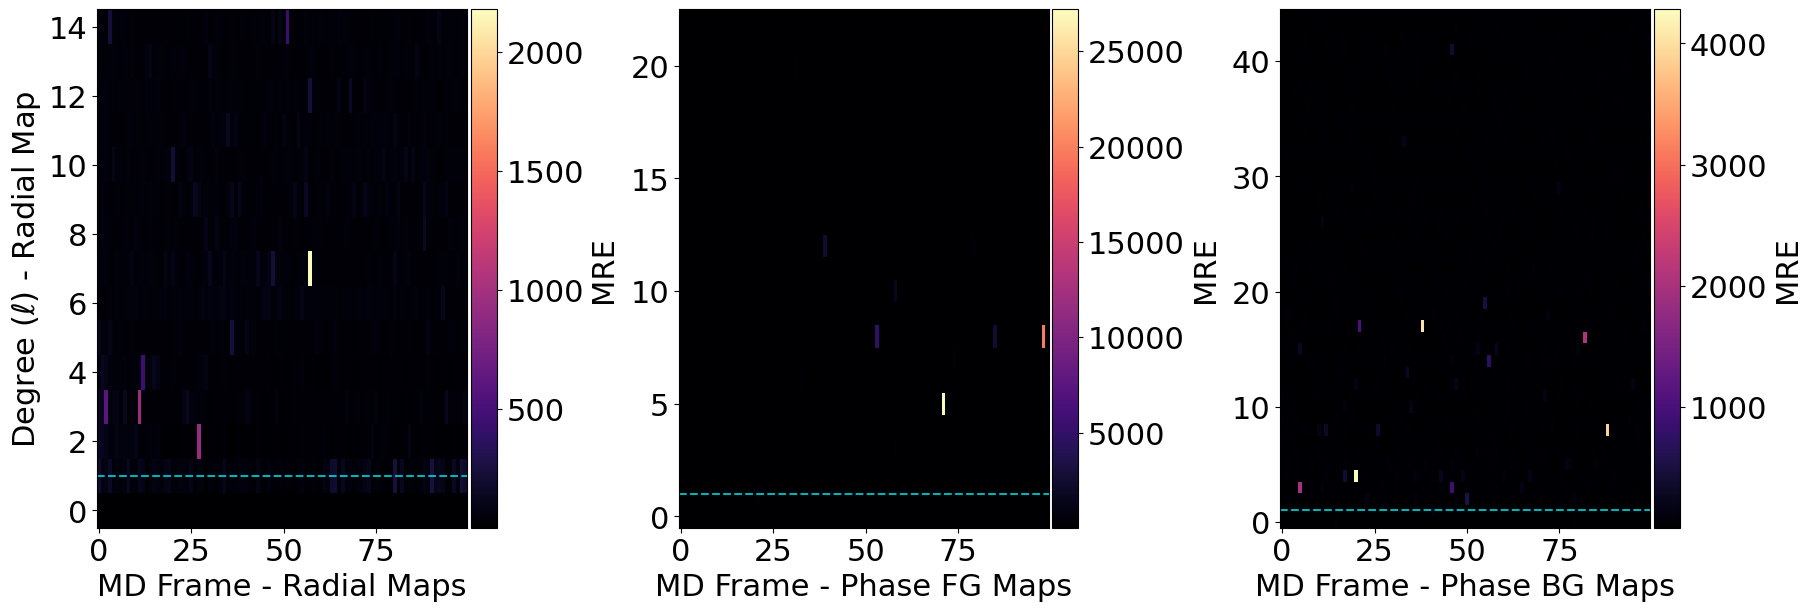


Finished Plot 1.
Generating Plot 2: Power Spectrum Residuals for model 'big_0rots_very_big_alms'...
Number of rows in 'spec' DataFrame after collection: 415
Number of rows in 'spec_agg' DataFrame after aggregation: 83


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

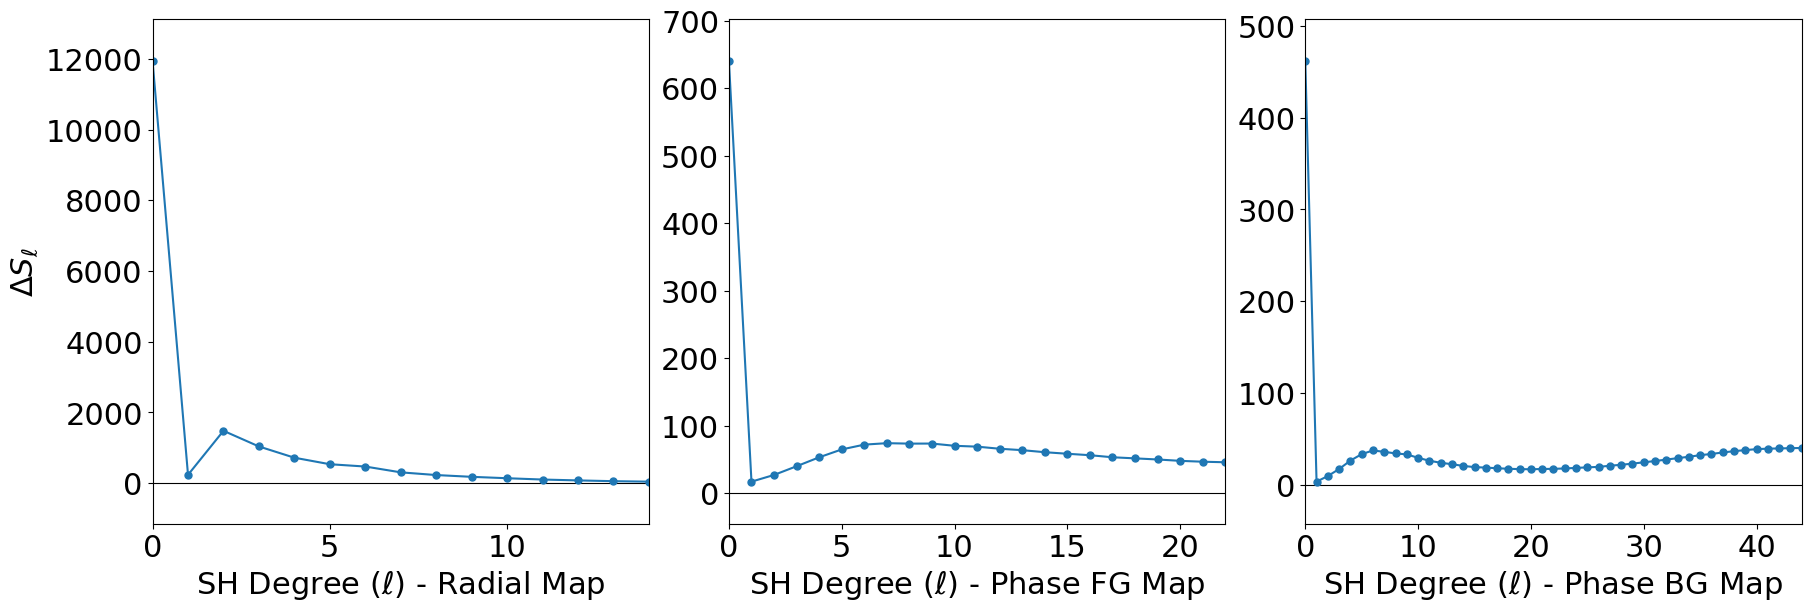


Finished Plot 2.


In [36]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, healpy as hp, re, os
from pathlib import Path

# --- User Paths and General Constants ---
ERR_TABLE   = "sh_error_stats.csv"
ROOT_PRED   = "."
ROOT_TRUTH  = "../"
LMAX        = {"radial": 14, "phase_fg": 22, "phase_bg": 44}
fields      = ["radial", "phase_fg", "phase_bg"]
target_model = 'big_0rots_very_big_alms'

# --- Matplotlib Font & Label Customization ---
plt.rcParams.update({
    "text.usetex": False, # Keep LaTeX for symbols like ell and Delta E_ell
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"], # Recommended font for LaTeX
    "font.size": 12
})

LABEL_FONTSIZE = 22
TICK_FONTSIZE = 22
CBAR_LABEL_FONTSIZE = 22

# Custom X-axis label dictionary for Plot 1 (Relative Error Heatmaps)
x_axis_label_names_rel_err = {
    "radial": "MD Frame - Radial Maps",
    "phase_fg": "MD Frame - Phase FG Maps",
    "phase_bg": "MD Frame - Phase BG Maps",
}

# Custom Y-axis label suffixes for Plot 1
y_axis_label_suffixes_rel_err = {
    "radial": "Radial Map",
    "phase_fg": "Phase FG Map",
    "phase_bg": "Phase BG Map",
}


# Custom X-axis Labels for Plot 2 (Power Spectrum Residual Line Plots)
custom_x_labels_plot2 = [
    r"SH Degree ($\ell$) - Radial Map",
    r"SH Degree ($\ell$) - Phase FG Map",
    r"SH Degree ($\ell$) - Phase BG Map",
]


# Custom Y-axis label suffixes for Plot 2
y_axis_label_suffixes_ps_res = {
    "radial": "Radial Map",
    "phase_fg": "Phase FG Map",
    "phase_bg": "Phase BG Map",
}


# ───────────────── Plot 1: Relative-Error Heatmaps (1x3 Layout) ─────────

print(f"Generating Plot 1: Relative Error Heatmaps for model '{target_model}'...")

df_err = pd.read_csv(ERR_TABLE)
df_err["model_type"] = df_err["model"].str.replace(r"^configf_\d+_", "", regex=True)

rel = (df_err.groupby(["model_type", "field", "frame", "degree"], as_index=False)
          ["mean_rel_err"].mean())
rel = rel[rel['model_type'] == target_model]

print(f"Model types found in 'sh_error_stats.csv': {df_err['model_type'].unique()}")
print(f"Number of rows in 'rel' DataFrame after filtering for '{target_model}': {len(rel)}")
if rel.empty:
    print(f"WARNING: 'rel' DataFrame is empty for model '{target_model}'. Plot will be empty.")

fig1, axes1 = plt.subplots(1, len(fields),
                           figsize=(len(fields) * 6, 6),
                           sharex=True, sharey=False,
                           constrained_layout=True)

if len(fields) == 1:
    axes1 = np.array([axes1])


for c, fld in enumerate(fields):
    ax = axes1[c]
    sub = rel[rel['field'] == fld]

    if sub.empty:
        print(f"WARNING: Sub-DataFrame for field '{fld}' for Plot 1 is empty.")

    heat = (sub.pivot(index="degree", columns="frame", values="mean_rel_err")
               .reindex(index=np.arange(0, LMAX[fld]+1),
                        columns=np.arange(1, 101)))

    im = ax.imshow(heat, aspect="auto", origin="lower",
                    interpolation="nearest", cmap="magma")

    if c == 0:
        ell_label = r"Degree ($\ell$)"
        ax.set_ylabel(f"{ell_label} - {y_axis_label_suffixes_rel_err[fld]}", fontsize=LABEL_FONTSIZE)
    else:
        ax.set_ylabel("", fontsize=LABEL_FONTSIZE)

    ax.set_xlabel(x_axis_label_names_rel_err.get(fld, f"MD Frame ({fld})"),
                  fontsize=LABEL_FONTSIZE)

    ax.tick_params(axis='x', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)

    ax.axhline(1, color='cyan', ls='--', lw=1.5, alpha=0.7)

    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label("MRE", fontsize=CBAR_LABEL_FONTSIZE)
    cbar.ax.tick_params(labelsize=TICK_FONTSIZE)
plt.savefig('interpolation_frame_mre.png', dpi=300)
plt.show()
print("\nFinished Plot 1.")


# ───────────────── Plot 2: Power-Spectrum Residual (1x3 Layout) ─────────

print(f"Generating Plot 2: Power Spectrum Residuals for model '{target_model}'...")

def alm_degree_map(lmax):
    l_idx, _ = hp.Alm.getlm(lmax)
    return l_idx

def collect_energy_per_degree():
    rows = []
    all_pred_dirs = [p for p in Path(ROOT_PRED).glob("configf_*_alms") if p.is_dir()]
    
    pred_dirs = []
    for p in all_pred_dirs:
        model_type_from_dir = re.sub(r"^configf_\d+_", "", p.name)
        if model_type_from_dir == target_model:
            pred_dirs.append(p)

    if not pred_dirs:
        print(f"WARNING: No prediction directories found for model '{target_model}' at '{ROOT_PRED}'.")
        return pd.DataFrame(columns=["model_type", "field", "degree", "dE"])

    for pred_dir in pred_dirs:
        cfg_id = re.search(r"configf_(\d+)", pred_dir.name).group(1)
        model_type = re.sub(r"^configf_\d+_", "", pred_dir.name)
        truth_dir = Path(ROOT_TRUTH) / f"configf_{cfg_id}"

        if not truth_dir.exists():
            print(f"WARNING: Truth directory '{truth_dir}' not found for config ID '{cfg_id}'. Skipping.")
            continue
        if not (pred_dir / "trajectory_alms.npz").exists():
            print(f"WARNING: 'trajectory_alms.npz' not found in '{pred_dir}'. Skipping.")
            continue

        try:
            traj = np.load(pred_dir / "trajectory_alms.npz")
            truth_rad = np.load(truth_dir / "outer_sh_radial_latent.npy")
            truth_fg  = np.load(truth_dir / "outer_sh_phase_latent_fg_lmax22.npy")
            truth_bg  = np.load(truth_dir / "outer_sh_phase_latent_bg_lmax44.npy")
        except FileNotFoundError as e:
            print(f"WARNING: Truth file not found in '{truth_dir}' or '{pred_dir}': {e}. Skipping this folder.")
            continue
        except KeyError as e:
            print(f"WARNING: Missing key in trajectory_alms.npz from '{pred_dir}': {e}. Skipping this folder.")
            continue

        for field, pred_arr, true_arr in [
            ("radial",   traj["radial"],   truth_rad[...,0]),
            ("phase_fg", traj["phase_fg"], truth_fg),
            ("phase_bg", traj["phase_bg"], truth_bg),
        ]:
            if pred_arr.ndim == 2: pred_arr = pred_arr[..., None]
            if true_arr.ndim == 2: true_arr = true_arr[..., None]
            
            if pred_arr.shape[0] != 100 or true_arr.shape[0] < 101:
                print(f"WARNING: Unexpected frame count for {field} in {pred_dir.name}. Pred: {pred_arr.shape[0]}, True: {true_arr.shape[0]}. Skipping this field.")
                continue
            
            true_arr_aligned = true_arr[1:101]

            lmax = LMAX[field]
            l_idx = alm_degree_map(lmax)
            for ℓ in range(lmax+1):
                mask = l_idx == ℓ
                if not np.any(mask):
                    continue

                E_pred_summed_mean = np.mean(np.sum(np.abs(pred_arr[:, mask, :])**2, axis=(1, 2)))
                E_true_summed_mean = np.mean(np.sum(np.abs(true_arr_aligned[:, mask, :])**2, axis=(1, 2)))
                
                dE = E_pred_summed_mean - E_true_summed_mean
                rows.append({"model_type": model_type,
                              "field": field, "degree": ℓ, "dE": float(dE)})
    return pd.DataFrame(rows)

spec = collect_energy_per_degree()

spec_agg = (spec.groupby(["model_type", "field", "degree"], as_index=False)["dE"]
                .mean())

print(f"Number of rows in 'spec' DataFrame after collection: {len(spec)}")
print(f"Number of rows in 'spec_agg' DataFrame after aggregation: {len(spec_agg)}")
if spec_agg.empty:
    print(f"WARNING: 'spec_agg' DataFrame is empty. Plot 2 will be empty. Check file paths and data content.")

fig2, axes2 = plt.subplots(1, len(fields),
                           figsize=(len(fields)*6, 6),
                           sharex=False, sharey=False, # <--- IMPORTANT: Changed sharey to False!
                           constrained_layout=True)

if len(fields) == 1:
    axes2 = np.array([axes2])

for c, fld in enumerate(fields):
    ax = axes2[c]
    sub = spec_agg[spec_agg['field'] == fld]

    if sub.empty:
        print(f"WARNING: Sub-DataFrame for field '{fld}' for Plot 2 is empty.")

    ax.axhline(0, color="k", lw=0.8)

    ax.plot(sub.degree, sub.dE, marker='o', markersize=5, linestyle='-', linewidth=1.5)

    ax.set_xlabel(custom_x_labels_plot2[c], fontsize=LABEL_FONTSIZE)

    if c == 0:
        ax.set_ylabel(r"$\Delta S_\ell$", fontsize=LABEL_FONTSIZE)
    else:
        ax.set_ylabel("", fontsize=LABEL_FONTSIZE)

    ax.tick_params(axis='x', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)

    ax.set_xlim(0, LMAX[fld])
    
    # --- Dynamically set Y-limits for THIS subplot (using 'sub' data) ---
    if not sub.empty:
        current_min_dE = sub['dE'].min()
        current_max_dE = sub['dE'].max()
        # Add some padding. Ensure 0 is always visible if applicable.
        padding_factor = 0.1
        min_lim = min(0, current_min_dE - (current_max_dE - current_min_dE) * padding_factor)
        max_lim = max(0, current_max_dE + (current_max_dE - current_min_dE) * padding_factor)
        
        # If range is very small (e.g., all dE are ~0), provide a small default range
        if abs(max_lim - min_lim) < 1e-6:
             min_lim, max_lim = -1, 1 
        ax.set_ylim(min_lim, max_lim)
    else:
        ax.set_ylim(-10, 10) # Default small range if no data
plt.savefig('interpolation_frame_respower.png', dpi=300)
plt.show()
print("\nFinished Plot 2.")

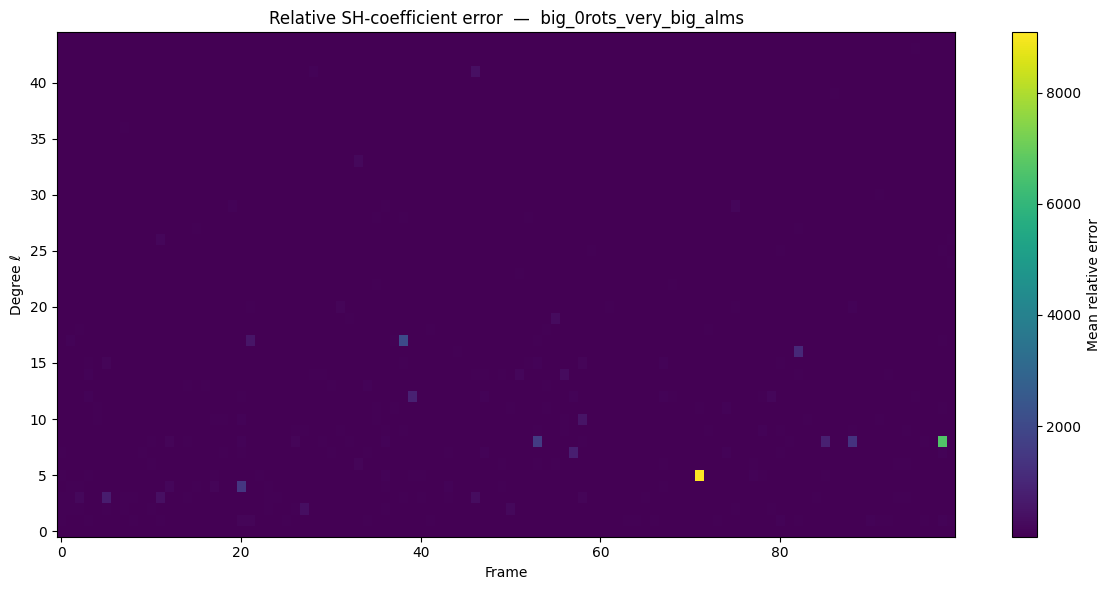

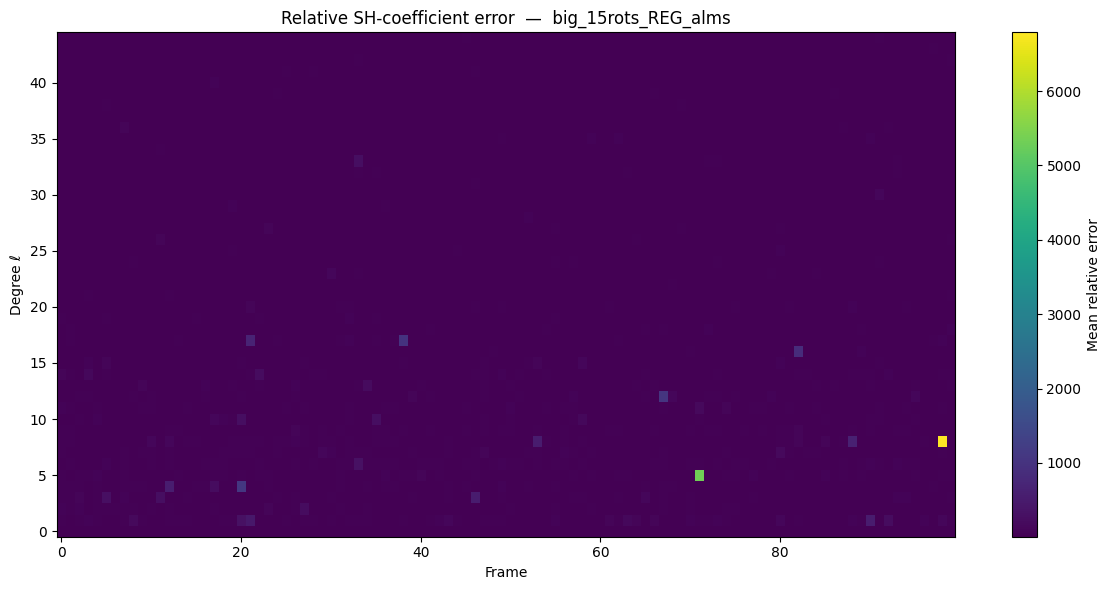

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


# ----------------------------------------------------------
# 2)  Derive a clean model label  (strip "configf_<id>_")
# ----------------------------------------------------------
df["model_type"] = df["model"].str.replace(r"^configf_\d+_", "",
                                           regex=True)

# ----------------------------------------------------------
# 3)  Average the RELATIVE error across all folders that share
#     the same model flavour and across all latent fields
# ----------------------------------------------------------
rel = (df.groupby(["model_type", "frame", "degree"],
                  as_index=False)["mean_rel_err"]
         .mean())

# ----------------------------------------------------------
# 4)  Plot one heat-map per model flavour
# ----------------------------------------------------------
for model in rel["model_type"].unique():
    sub = rel[rel["model_type"] == model]

    heat = (sub.pivot(index="degree", columns="frame", values="mean_rel_err")
               .reindex(index=np.arange(0, 45),
                        columns=np.arange(1, 101)))

    plt.figure(figsize=(12, 6))
    im = plt.imshow(heat, aspect="auto",
                    origin="lower", interpolation="nearest")
    plt.colorbar(im, label="Mean relative error")
    plt.title(f"Relative SH-coefficient error  —  {model}")
    plt.xlabel("Frame")
    plt.ylabel("Degree ℓ")
    plt.tight_layout()
    plt.show()


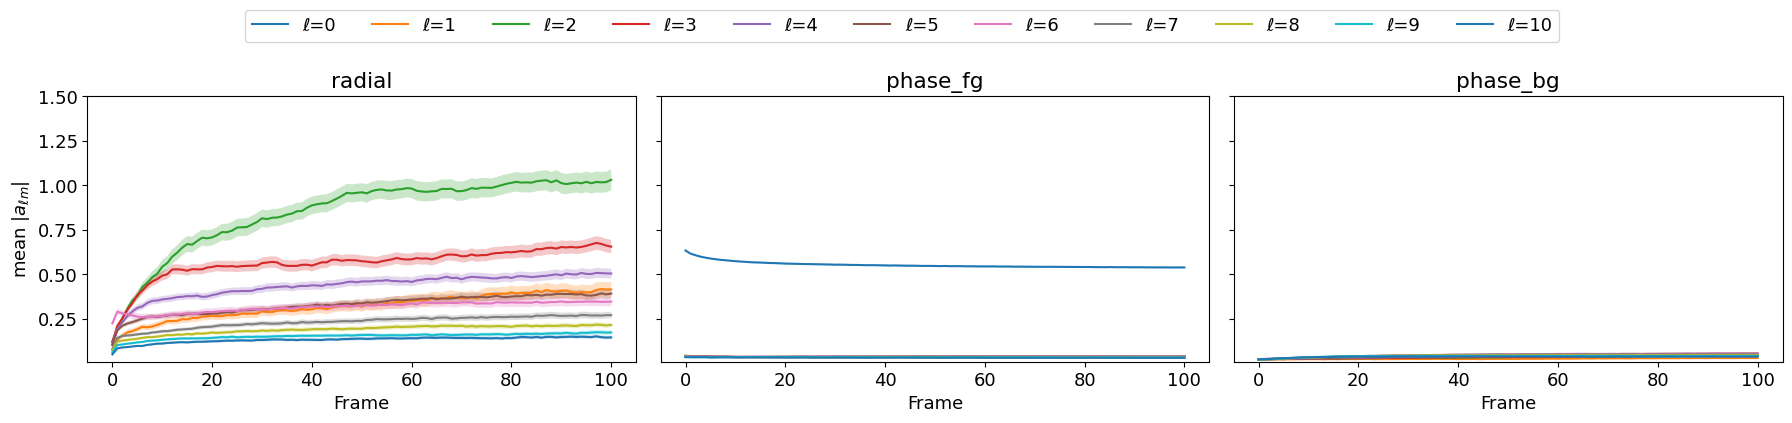

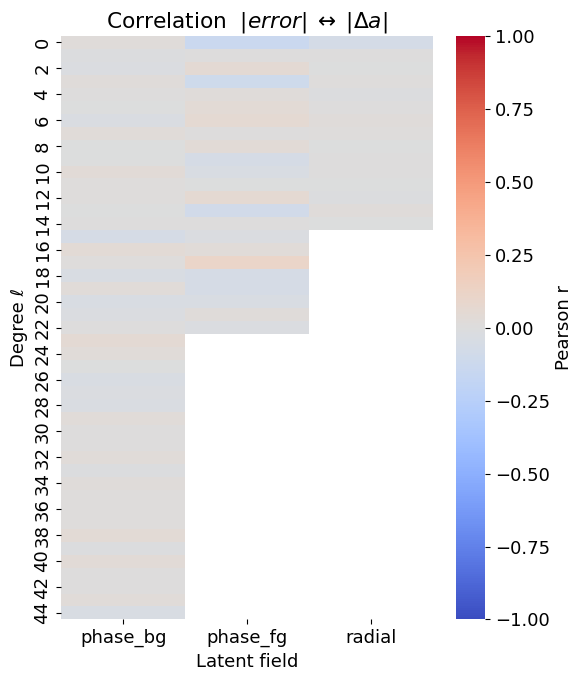

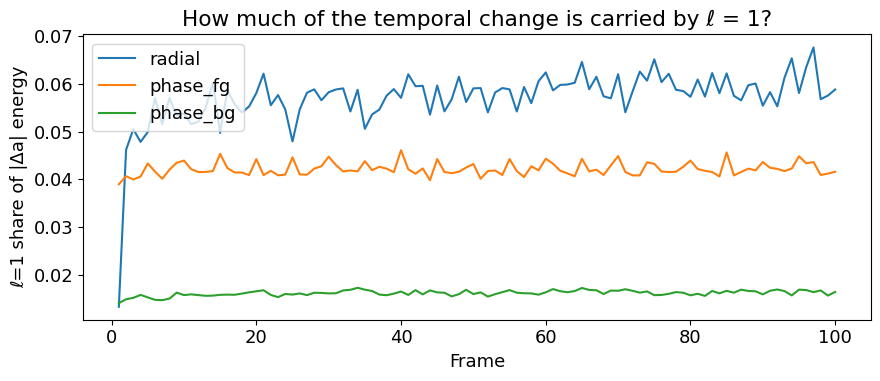

In [32]:
#  ╔═══════════════════════════════════════════════════════╗
#  ║  SH dynamics  ➜  error linkage (shape-aware version)  ║
#  ╚═══════════════════════════════════════════════════════╝
import numpy as np, pandas as pd, healpy as hp, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
import random, math, json, os

# ─────────────── user paths & params ────────────────
ROOT_TRUTH    = Path("../")               # configf_<id> folders live here
TEST_LIST_TXT = "../test_folders_final.txt"
ERR_DF_FILE   = "sh_error_stats.csv"      # absolute-error table from earlier
SEED          = 42
YLIM          = (0.01, 1.0)
MAX_DEG_PLOT  = 10
plt.rcParams.update({"font.size": 13})

# ───────────────── helper: load one latent array ─────────────────
def load_latent(folder: Path, field: str) -> np.ndarray:
    name = {"radial":   "outer_sh_radial_latent.npy",
            "phase_fg": "outer_sh_phase_latent_fg_lmax22.npy",
            "phase_bg": "outer_sh_phase_latent_bg_lmax44.npy"}[field]
    arr = np.load(folder / name)          # shapes exactly as specified
    if field == "radial" and arr.ndim == 2:                 # (T,M) → add dummy ch
        arr = arr[..., None]              # → (T,M,1)
    return arr                            # always (T,M,C)

# ───────────────── helper: Alm-magnitude by degree ───────────────
def mags_by_degree(arr_TMC: np.ndarray) -> dict[int, np.ndarray]:
    """Return {ℓ: (T,) mean |a_{ℓm}| over m & channel}."""
    T, M, C = arr_TMC.shape
    lmax = hp.Alm.getlmax(M)
    l_idx, _ = hp.Alm.getlm(lmax)
    mags = np.abs(arr_TMC).transpose(0, 2, 1)   # (T,C,M)
    return {ℓ: mags[:, :, l_idx == ℓ].mean(axis=(1, 2))
            for ℓ in range(lmax + 1)}

# ───────────────── collect ground-truth series ──────────────────
random.seed(SEED)
with open(TEST_LIST_TXT) as fp:
    truth_folders = [ROOT_TRUTH / ln.strip() for ln in fp if ln.strip()]
#truth_folders = random.sample(truth_folders, len(truth_folders))

mag_rows, delta_rows = [], []
for folder in truth_folders:
    for field in ["radial", "phase_fg", "phase_bg"]:
        arr = load_latent(folder, field)         # (101,M,C)
        mags = mags_by_degree(arr)
        diffs = mags_by_degree(np.diff(arr, axis=0))  # (100, …)
        for ℓ, vec in mags.items():              # magnitudes
            mag_rows.extend({"folder": folder.name, "field": field,
                              "frame": f, "degree": ℓ, "mag": float(val)}
                             for f, val in enumerate(vec))
            delta_rows.extend({"folder": folder.name, "field": field,
                                "frame": f+1, "degree": ℓ, "delta": float(val)}
                               for f, val in enumerate(diffs[ℓ]))

df_mag   = pd.DataFrame(mag_rows)
df_delta = pd.DataFrame(delta_rows)

# ─────────────── 1) magnitude evolution plots ──────────────────
agg = (df_mag.groupby(["field", "frame", "degree"])
              .agg(mean=("mag", "mean"), sem=("mag", "sem"))
              .reset_index())
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
for ax, fld in zip(axes, ["radial", "phase_fg", "phase_bg"]):
    sub = agg.query("field == @fld and degree <= @MAX_DEG_PLOT")
    for ℓ in range(MAX_DEG_PLOT + 1):
        s = sub[sub["degree"] == ℓ]
        ax.plot(s["frame"], s["mean"], label=f"ℓ={ℓ}")
        ax.fill_between(s["frame"], s["mean"]-s["sem"], s["mean"]+s["sem"], alpha=.25)
    if fld == 'radial':
        ax.set_title(fld); ax.set_xlabel("Frame"); ax.set_ylim(*YLIM)
    else:
        ax.set_title(fld); ax.set_xlabel("Frame"); ax.set_ylim(0.01,1.5)
axes[0].set_ylabel(r"mean $|a_{\ell m}|$")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=MAX_DEG_PLOT+1,
           loc="upper center", bbox_to_anchor=(0.5, 1.08))
fig.tight_layout(rect=[0,0,1,0.95]); plt.show()

# ─────────────── 2) |error| vs |Δa| correlation ────────────────
df_err = pd.read_csv(ERR_DF_FILE)              # produced earlier
err_mean = (df_err.groupby(["field", "frame", "degree"])
                    ["mean_abs_err"].mean().reset_index())
corr_rows = []
for fld in ["radial", "phase_fg", "phase_bg"]:
    merged = pd.merge(err_mean[err_mean.field == fld],
                      df_delta[df_delta.field == fld],
                      on=["frame", "degree"], how="inner")
    for ℓ in merged.degree.unique():
        sub = merged[merged.degree == ℓ]
        if len(sub) > 1:
            r = np.corrcoef(sub.mean_abs_err, sub.delta)[0,1]
            corr_rows.append({"field": fld, "degree": ℓ, "r": r})
heat = pd.DataFrame(corr_rows).pivot(index="degree", columns="field", values="r")
plt.figure(figsize=(6,7))
sns.heatmap(heat, vmin=-1, vmax=1, cmap="coolwarm",
            cbar_kws={"label": "Pearson r"})
plt.title(r"Correlation  $|error|\; \leftrightarrow\; |\Delta a|$")
plt.ylabel("Degree ℓ"); plt.xlabel("Latent field"); plt.tight_layout(); plt.show()

# ─────────────── 3) ℓ=1 share of |Δa| energy ──────────────────
tot = (df_delta.groupby(["field", "frame"])["delta"]
                .sum().reset_index(name="total"))
l1  = (df_delta.query("degree == 1")
                .groupby(["field", "frame"])["delta"].sum()
                .reset_index(name="l1"))
frac = pd.merge(tot, l1, on=["field","frame"])
frac["fraction"] = frac.l1 / frac.total
plt.figure(figsize=(9,4))
for fld in ["radial", "phase_fg", "phase_bg"]:
    s = frac[frac.field == fld]
    plt.plot(s.frame, s.fraction, label=fld)
plt.xlabel("Frame"); plt.ylabel("ℓ=1 share of |Δa| energy")
plt.title("How much of the temporal change is carried by ℓ = 1?")
plt.legend(); plt.tight_layout(); plt.show()
